In [ ]:
import numpy as np
import pandas as pd

import math

from collections import deque

from random import random as rand
from random import randint

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from scipy.stats import entropy

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# First define the device for if using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on ' + device.type)

Running on cpu


In [ ]:
# Simple helper for initializing grid backdrops
def init_a(size):
    return np.full((size, size), False, dtype=bool)

In [ ]:
# General setup params

# Params controlling episode count and length
n_episodes = 75000
min_iters_per_episode = 40 # We'll setp up the length of the episodes from a minimum number
max_iters_per_episode = 75 # ...to a maximum number
l_episode_lengths = np.geomspace(min_iters_per_episode
                                 , max_iters_per_episode
                                 , num=n_episodes).astype(int).tolist() # ...in geometric increments
n_sample_every = 2500 # every this many episodes, store a gif and statedict

# Params reated to genera environment structure
grid_size = 16
n_start_bots = 2
l_n_targets = np.geomspace(24, 8, num=n_episodes).astype(int).tolist() # This allows us to decay the number of targets but keep it high early
n_targets = l_n_targets[0] # for instance, for the first episode, it's the first item in the list
vision_size = 4 # number of spaces the bots can see in either direction
stun_dist_red = 1 # how far (red or blue's) stun line reaches out
stun_dist_blue = 3
stun_duration = 4 # how many timesteps a target stays stunned

# Params related to rewards and training handling
reward_red = False
reward_closer = 1 # reward for getting closer to any objective
reward_farther = -1 # reward for getting farther from all objective
reward_invalid = -1 # reward if move is invalid
reward_blue_move_mult = 1 # multiplier for blues movement rewards that allows those rewards to decay
blue_mult_decay = 0.99995 # rate of decay for blue's movement reward
reward_inaction = 0 # reward for choosing the "do nothing" actions
reward_target_attempt = 0 # allows a reward to encourage attempting targets
reward_target = 1 # reward for securing a target
reward_stun_attempt = 0.1 # allows a reward to encourage attempting stunning targets
reward_stun = 0 # allows for reward on successful stun
reward_stun_miss = -0.1 # penalty for essentially blindly firing stun
reward_stun_proximity = 15 # extra reward for getting a stun within a certain range of red
stun_proximity_cap = 3 # stun distance near red to count for the proximity reward
reward_stun_same = -5 # penalty multiplier if stun is chosen on the same target
reward_constant_penalty = -0.1 # constant negative reward always given to disincentivize sitting still
entropy_mult_main = -0.001 # how much a lack of entropy in choices negatively affects bots
entropy_mult_dir = -0.01 # how much a lack of entropy effects direction choices for main target moves
entropy_mult_decay = 0.99995 # fractional decay per episode of entropy_mult_main

# Params related to the networks/training
l_rate = 0.0002 # learning rate for optimizer
gamma = 0.98 # the discount rate for our reward system

# Convenience vars (not necessarily customizable, below aligns naturally with code)
n_action_types = 3 # only for convenience, must actually remap below if changing
n_action_space = 1 + (n_action_types * 8) # 1 "nothing" action, plus n action types * 8 directionality options
vision_dimz = (vision_size * 2) + 1 # the width and height of the vision arrays (because we see vision_size in both directions)

# Storing of team and total scores
l_red_raw_scores_episode = [] # these used to track end of episode scores, raw is training scores, objective are for actual goals
l_blue_raw_scores_episode = []
l_red_moving_raw_score = deque(maxlen=50)
l_blue_moving_raw_score = deque(maxlen=50)
l_red_moving_obj_score = deque(maxlen=50)
l_blue_moving_obj_score = deque(maxlen=50)
l_red_obj_scores_episode = []
l_blue_obj_scores_episode = []
l_red_obj_scores_playback = [] # these used for gif playback
l_blue_obj_scores_playback = []
l_red_raw_scores_playback = []
l_blue_raw_scores_playback = []

# Empty lists to store our objects in
l_bots_red = []
l_bots_blue = []
l_targets = []

# Arrays to store taken locations in
a_bots_red = init_a(grid_size)
a_bots_blue = init_a(grid_size)
a_targets = init_a(grid_size)
a_stuns = init_a(grid_size)
a_impass = init_a(grid_size) # for tracking all open positions

# Filepaths for recordings
fp_a_bots_red = 'a_bots_r.txt'
fp_a_bots_blue = 'a_bots_b.txt'
fp_a_targets = 'a_targets.txt'
fp_a_stuns = 'a_stuns.txt'
fp_gif = '/content/drive/MyDrive/Gridbots_Temp/grid_animation'
fp_red_brain_statedict = '/content/drive/MyDrive/Gridbots_Temp/red_brain_statedict'
fp_blue_brain_statedict = '/content/drive/MyDrive/Gridbots_Temp/blue_brain_statedict'
fp_red_optim_statedict = '/content/drive/MyDrive/Gridbots_Temp/red_optim_statedict'
fp_blue_optim_statedict = '/content/drive/MyDrive/Gridbots_Temp/blue_optim_statedict'

In [ ]:
# Way tocalculate entropy (useful for penalizing same moves over and over)
def calc_entropy(a):
    vals, val_counts = np.unique(a, return_counts=True)
    p_vals = val_counts / val_counts.sum()
    if len(vals) == 1:
        e = 0.01
    else:
        e = entropy(p_vals, base=2)
    return e

# Scale the entropy calculated above into a loss by taking in an array of choices (scales with multiplier and number of timesteps)
def entropy_loss(a, mult=entropy_mult_main):
    return mult * len(a) / calc_entropy(a)

In [ ]:
class bot_brain(nn.Module):
    
    def __init__(self):
        super(bot_brain, self).__init__()

        # General shape params
        self.input_chan = 4
        self.input_dimz = vision_dimz # the width and height will be the same as the vision dimensions
        self.conv_dim = 20 # the "base" number of filters to use in the first conv layer
        self.output_nodes = n_action_space

        # Some misc handling params
        self.padding_mode = 'replicate'
        self.lrelu_scale = 0.2

        # Values for the first conv layer
        self.ksize_1 = 3
        self.stride_1 = 2
        self.padding_1 = 1

        # Values for the second conv layer
        self.ksize_2 = 3
        self.stride_2 = 2
        self.padding_2 = 1

        # Values for the third conv layer
        self.ksize_3 = 3
        self.stride_3 = 2
        self.padding_3 = 1

        # Now our actual conv layers
        self.conv1 = nn.Conv2d(self.input_chan, self.conv_dim, self.ksize_1,
                               self.stride_1, self.padding_1, padding_mode=self.padding_mode)
        self.conv2 = nn.Conv2d(self.conv_dim, self.conv_dim * 2, self.ksize_2,
                               self.stride_2, self.padding_2, padding_mode=self.padding_mode)
        self.conv3 = nn.Conv2d(self.conv_dim * 2, self.conv_dim * 3, self.ksize_3,
                               self.stride_3, self.padding_3, padding_mode=self.padding_mode)
        
        # Get the number of nodes coming out of the conv network
        # = dimensions of last conv layer * number of filters
        self.n_conv_output = ((self.input_dimz - 7) ** 2) * (self.conv_dim * 3)
        # And the number of nodes for the next layer output
        self.n_output_1 = int(self.n_conv_output / 2)

        # Now our LSTM and fully connected layers
        self.lstm_1 = nn.LSTM(self.n_conv_output
                            , self.n_output_1
                            , batch_first=True)
        self.linear_action = nn.Linear(self.n_output_1, self.output_nodes)
        self.linear_critic = nn.Linear(self.n_output_1, 1)


    def forward(self, x, lstm_1_h, lstm_1_c):

      # Run through all of our layers defined above
      x = F.leaky_relu(self.conv1(x), self.lrelu_scale)
      x = F.leaky_relu(self.conv2(x), self.lrelu_scale)
      x = F.leaky_relu(self.conv3(x), self.lrelu_scale)
      x = x.view(-1, self.n_conv_output) # flatten the conv layer
      # Run through the lstms, don't forget hidden/cell input outputs and to detatch (so as to not keep gradient through all memory)
      x, (lstm_1_h_new, lstm_1_c_new) = self.lstm_1(x, (lstm_1_h.detach(), lstm_1_c.detach()))
      action_probs = F.softmax(self.linear_action(x), dim=1)
      critic_value = self.linear_critic(x)

      return action_probs, critic_value, lstm_1_h_new, lstm_1_c_new

    def decide_action(self, x, lstm_1_h, lstm_1_c):

      # Create the prob distribution from output and return the action/logprob
      action_probs, critic_value, lstm_1_h_new, lstm_1_c_new = self.forward(x, lstm_1_h, lstm_1_c)
      prob_dist = Categorical(action_probs)
      action = prob_dist.sample()
      action_item = action.item()
      logp = prob_dist.log_prob(action)

      return action_item, logp, critic_value, lstm_1_h_new, lstm_1_c_new

In [ ]:
# Set up our team brains using the above as well as their optimizers
team_brain_red = bot_brain().to(device)
team_brain_blue = bot_brain().to(device)
team_optim_red = optim.Adam(team_brain_red.parameters(), lr=l_rate)
team_optim_blue = optim.Adam(team_brain_blue.parameters(), lr=l_rate)

In [ ]:
# Load statedicts if we've already done some training
# team_brain_red.load_state_dict(torch.load('/content/drive/MyDrive/Gridbots_Temp/first_run/red_brain_statedict_75000.pth'))
# team_brain_blue.load_state_dict(torch.load('/content/drive/MyDrive/Gridbots_Temp/first_run/blue_brain_statedict_75000.pth'))
# team_brain_red.to(device)
# team_brain_blue.to(device)
# team_optim_red.load_state_dict(torch.load('/content/drive/MyDrive/Gridbots_Temp/first_run/red_optim_statedict_75000.pth'))
# team_optim_blue.load_state_dict(torch.load('/content/drive/MyDrive/Gridbots_Temp/first_run/blue_optim_statedict_75000.pth'))

In [ ]:
class bot():
    
    def __init__(self, start_x=0, start_y=0, brain=team_brain_red, team='red'):
        
        # Contextual/positional attributes
        self.x_loc = start_x
        self.y_loc = start_y
        self.team = team

        # We need some dimensions based on the team's bot_brain
        # These are realistically the same, but we pull as such just in case
        if team == 'red':
            self.n_output_1 = team_brain_red.n_output_1
        else:
            self.n_output_1 = team_brain_blue.n_output_1

        # Memory based attributes
        self.lstm_1_h = torch.zeros(1, self.n_output_1).to(device)
        self.lstm_1_c = torch.zeros(1, self.n_output_1).to(device)

        # Reward and training related tracking
        self.current_ts_reward = 0
        self.previous_stun_loc = None
        self.l_type_choices = []
        self.l_dir_choices = []
        self.l_episode_rewards = []
        self.l_episode_log_probs = []
        self.l_episode_critic_values = []

    def reset_memory(self):
        self.lstm_1_h = torch.zeros(1, self.n_output_1).to(device)
        self.lstm_1_c = torch.zeros(1, self.n_output_1).to(device)

In [ ]:
class target():
    
    def __init__(self, start_x=0, start_y=0):
        
        self.x_loc = start_x
        self.y_loc = start_y
        self.stun_countdown = 0

In [ ]:
# Function to set initial positions and grids of objects
def init_positions(object_type, object_list, object_array, n, object_group=None):

    # Function will iteratively search for a valid position (checking against what's already taken)
    valid_position = False

    # Runs for n objects needed to be created
    for i in range(n):

        while valid_position == False:

            # Pick a random x,y pair
            start_x = randint(0, grid_size - 1)
            start_y = randint(0, grid_size - 1)

            # Check if that position is available
            if a_impass[start_y, start_x] == False:
                
                # If so, acknowledge this position will now be taken
                valid_position = True
                
                a_impass[start_y, start_x] = True
                object_array[start_y, start_x] = True
                
                # Append the object to its relevant list
                if object_group: # Some objects may have groups, so allow a handling for that
                    object_list.append(object_type(start_x=start_x, start_y=start_y, team=object_group))
                else:
                    object_list.append(object_type(start_x=start_x, start_y=start_y))
                
        # Reset the while loop for the next run
        valid_position = False

In [ ]:
# Initialize all our positions
init_positions(bot, l_bots_red, a_bots_red, n_start_bots, 'red')
init_positions(bot, l_bots_blue, a_bots_blue, n_start_bots, 'blue')
init_positions(target, l_targets, a_targets, n_targets)

In [ ]:
# Function used to reset an object type's positions
def reset_positions(object_list, object_array):

    # Function will iteratively search for a valid position (checking against what's already taken)
    valid_position = False

    # Runs for n objects needed to be created
    for obj in object_list:

        # Get the object's current position
        x_old, y_old = obj.x_loc, obj.y_loc

        while valid_position == False:

            # Pick a random x,y pair
            x_new = randint(0, grid_size - 1)
            y_new = randint(0, grid_size - 1)

            # Check if that position is available
            if a_impass[y_new, x_new] == False:
                
                # If so, acknowledge this position will now be taken
                valid_position = True
                
                # Update the arrays for the new positions
                a_impass[y_new, x_new] = True
                object_array[y_new, x_new] = True

                # Update the objects new position
                obj.x_loc = x_new
                obj.y_loc = y_new
                
                # Set the old position as empty
                a_impass[y_old, x_old] = False
                object_array[y_old, x_old] = False          

        # Reset the while loop for the next run
        valid_position = False

In [ ]:
# Helpfer functions to saving and loading our numpy arrays to lookback on our work

# Store arrays as a text file
def save_a(a, fp):
    
    with open(fp, 'a') as f:
        np.savetxt(f, a, delimiter='\n')

# Store all arrays we're interested in
def save_all_a():

    save_a(a_bots_red, fp_a_bots_red)
    save_a(a_bots_blue, fp_a_bots_blue)
    save_a(a_targets, fp_a_targets)
    save_a(a_stuns, fp_a_stuns)

# Load our array, assuming shape is that of the grid
def load_grid_a(fp, playback_iters):
    
    return np.genfromtxt(fp, delimiter='\n').reshape(playback_iters, grid_size, grid_size)

In [ ]:
# For cleaning up text files no longer needed after creating animation
def cleanup_files():
    os.remove(fp_a_bots_red)
    os.remove(fp_a_bots_blue)
    os.remove(fp_a_targets)
    os.remove(fp_a_stuns)

In [ ]:
# Setup for plotting our simulation as a gif

# Define some color maps that will be used in our plotting
cmap_stun = ListedColormap(['none', 'black'])
cmap_red = ListedColormap(['none', 'r'])
cmap_blue = ListedColormap(['none', 'b'])
cmap_target = ListedColormap(['none', 'g'])

# Helper function just for test plots (only handy as a one-off)
# def plot_grid(red_positions, blue_positions, target_positions, stun_positions):
#     fig, ax = plt.subplots(figsize=(10,10))
#     plt.imshow(red_positions, vmin=0, vmax=1, cmap=cmap_red, axes=ax)
#     plt.imshow(blue_positions, vmin=0, vmax=1, cmap=cmap_blue, axes=ax)
#     plt.imshow(target_positions, vmin=0, vmax=1, cmap=cmap_target, axes=ax)
#     plt.imshow(stun_positions, vmin=0, vmax=1, cmap=cmap_stun, axes=ax)
#     plt.show()

# Function for generating our gif representing the simulation
def generate_gif(suffix, playback_iters):

    print('Generating gif...')
    
    # Load our arrays that tracked the sim
    record_a_stuns = load_grid_a(fp_a_stuns, playback_iters)
    record_a_bots_red = load_grid_a(fp_a_bots_red, playback_iters)
    record_a_bots_blue = load_grid_a(fp_a_bots_blue, playback_iters)
    record_a_targets = load_grid_a(fp_a_targets, playback_iters)
    
    # Set up the plot space
    fig, ax = plt.subplots(figsize=(10,10))
    plt.xlim((0, grid_size - 1))
    plt.ylim((0, grid_size - 1))
    plt.xticks(np.arange(0, grid_size - 1, 2))
    plt.yticks(np.arange(0, grid_size - 1, 2))
    
    # Setup the elements of the plot that will be animated
    starter_a = init_a(grid_size) # plt wants an initial data to plot, so we just set some blank array to start
    im_bots_stun = plt.imshow(starter_a, vmin=0, vmax=1, cmap=cmap_stun, axes=ax)
    im_bots_red = plt.imshow(starter_a, vmin=0, vmax=1, cmap=cmap_red, axes=ax)
    im_bots_blue = plt.imshow(starter_a, vmin=0, vmax=1, cmap=cmap_blue, axes=ax)
    im_bots_target = plt.imshow(starter_a, vmin=0, vmax=1, cmap=cmap_target, axes=ax)

    # Set up score tracking artists
    red_text_score = 'Red acquired targets: '
    red_score_text = ax.text(
      x=0
      , y=grid_size - 0.5
      , s=red_text_score + ' 0'
      , horizontalalignment='left'
      , size=10
      , color='red'
    )
    blue_text_score = 'Blue stunned targets: '
    blue_score_text = ax.text(
      x=grid_size - 1
      , y=grid_size - 0.5
      , s=blue_text_score + ' 0'
      , horizontalalignment='right'
      , size=10
      , color='blue'
    )
    
    # We need a function to handle animating (on the ith element of our overall data)
    def animate(i):
        
        # Change each plot element to the ith data element
        im_bots_stun.set_data(record_a_stuns[i])
        im_bots_red.set_data(record_a_bots_red[i])
        im_bots_blue.set_data(record_a_bots_blue[i])
        im_bots_target.set_data(record_a_targets[i])
        red_text = red_text_score + str(l_red_obj_scores_playback[i]) + ' | raw score: ' + str(round(l_red_raw_scores_playback[i], 2))
        red_score_text.set_text(red_text)
        blue_text = blue_text_score + str(l_blue_obj_scores_playback[i]) + ' | raw score: ' + str(round(l_blue_raw_scores_playback[i], 2))
        blue_score_text.set_text(blue_text)
        
        # Return the above (but must be in the form of a list)
        return [im_bots_stun], [im_bots_red], [im_bots_blue], [im_bots_target], [red_score_text], [blue_score_text]
    
    # Run our animation
    grid_animator = animation.FuncAnimation(fig, func=animate, frames=playback_iters, interval=100, repeat_delay=5000)
    # Write it to a file
    pillow = animation.PillowWriter(fps=1)
    grid_animator.save(fp_gif + f'_{suffix}.gif', writer=pillow)

    # Cleanup old array text files and any lists
    del l_red_obj_scores_playback[:]
    del l_blue_obj_scores_playback[:]
    del l_red_raw_scores_playback[:]
    del l_blue_raw_scores_playback[:]
    cleanup_files()

    # Close out all plt windows so they don't build up over the loops
    plt.close('all')
    
    print('Done building gif.')

In [ ]:
# Helper functions for mapping action indices to directions and types

# Creates a list separated by 8 steps (8 directions) given an index base
# List length is determined by total number of action types
def create_direction_set(index_base):
    
    return [(index_base + (8 * i)) for i in range(n_action_types)]

# Define directionality sets (list of action indices for a given direction)
l_directions_u = create_direction_set(1)
l_directions_ur = create_direction_set(2) # i.e. up right
l_directions_r = create_direction_set(3)
l_directions_dr = create_direction_set(4)
l_directions_d = create_direction_set(5)
l_directions_dl = create_direction_set(6) # i.e. down left
l_directions_l = create_direction_set(7)
l_directions_ul = create_direction_set(8)

# Define some action type sets
l_action_set_1 = np.arange(1, (8 * 1) + 1)
l_action_set_2 = np.arange((8 * 1) + 1, (8 * 2) + 1)
l_action_set_3 = np.arange((8 * 2) + 1, (8 * 3) + 1)

# Maps an action index to a directionality (and returns the x,y offset)
def map_action_direction(action_index):
    
    if action_index == 0:
        x_adjust = 0
        y_adjust = 0
    elif action_index in (l_directions_u):
        x_adjust = 0
        y_adjust = 1
    elif action_index in (l_directions_ur):
        x_adjust = 1
        y_adjust = 1
    elif action_index in (l_directions_r):
        x_adjust = 1
        y_adjust = 0
    elif action_index in (l_directions_dr):
        x_adjust = 1
        y_adjust = -1
    elif action_index in (l_directions_d):
        x_adjust = 0
        y_adjust = -1
    elif action_index in (l_directions_dl):
        x_adjust = -1
        y_adjust = -1
    elif action_index in (l_directions_l):
        x_adjust = -1
        y_adjust = 0
    elif action_index in (l_directions_ul):
        x_adjust = -1
        y_adjust = 1
    else:
        x_adjust = None
        y_adjust = None

    return (x_adjust, y_adjust)

# Maps an action index to an action type
def map_action_type(action_index):
    
    if action_index == 0:
        action_type = 'none'
    elif action_index in l_action_set_1:
        action_type = 'move'
    elif action_index in l_action_set_2:
        action_type = 'target'
    elif action_index in l_action_set_3:
        action_type = 'stun'
    else:
        action_type = None # in which case it's an actual error/bug
        
    return action_type

In [ ]:
# Helper function to make sure an x,y isn't off the grid
def is_valid_loc(x, y):
    
    x_is_valid = (0 <= x < grid_size)
    y_is_valid = (0 <= y < grid_size)
    loc_is_valid = x_is_valid and y_is_valid
    
    return loc_is_valid

In [ ]:
# Function for finding a "vision" array giving an x,y center coord and the array
# Out-of-bounds are padded with -1s
def vision_a(a, x, y, vision_limit=vision_size):

  # Convert the (boolean) array to int
  a_int = a.astype(int)
  # Get the x,y ranges based on the vision size
  x_left, x_right = x - vision_limit, x + vision_limit
  y_down, y_up = y + vision_limit, y - vision_limit
  # Pad the array to handle out of bounds
  padded_array = np.pad(a_int, vision_limit, mode='constant', constant_values=-1)
  # Slice the padded array
  # Note we need to account for added vision size to the index, that "up" are lower values, and the effect of slicing
  vision_array = padded_array[
        (y_up + vision_limit):(y_down + vision_limit + 1)
        , (x_left + vision_limit):(x_right + vision_limit + 1)
        ]

  return vision_array

In [ ]:
# Function to prepare vision input to bot's network given its location
def prep_vision(x, y):

    # Create an individual vision array for all the relevant inputs
    l_input_arrays = [
      a_bots_red
      , a_bots_blue
      , a_targets
      , a_impass 
      ]
    l_vision_arrays = [vision_a(a, x, y) for a in l_input_arrays]

    # Stack the arrays together
    a_vision_all = np.stack(l_vision_arrays)

    # Create the tensor version of the array
    # Reshape it so that it's batch dim (only 1) x n chans x width x height
    t_vision_all = torch.FloatTensor(a_vision_all)\
      .view(-1, len(l_input_arrays), vision_dimz, vision_dimz)

    return t_vision_all

In [ ]:
# Helper functions related to seeing if movement brought a bot closer to a target

# Function for simple euclidean distance
def euclidean_dist(x1, y1, x2, y2):

  x_dist = (x2 - x1) ** 2
  y_dist = (y2 - y1) ** 2
  dist = (x_dist + y_dist) ** 0.5

  return dist

# Function that returns the shortest distance to an object (from a given array)
# Input is the x,y coord of the bot
def shortest_object_dist(x1, y1, a):

  # Array of idxs where a target exists
  target_coords = np.argwhere(a == True)

  # Loop through all coords and append distances to a list
  distances = []
  for coord in target_coords:
    y2 = coord[0]
    x2 = coord[1]
    distances.append(euclidean_dist(x1, y1, x2, y2))

  # Return the shortest distance
  return min(distances)

In [ ]:
# Setup for moving targets on each timestep away from bots

# Convenience list of possible directions a target could move in
l_possible_adjustments = [
    (0,0) # stay
    , (0,1) # up
    , (0,-1) # down
    , (1,0) # right
    , (1,1) # up right
    , (1,-1) # down right
    , (-1,0) # left
    , (-1,1) # up left
    , (-1,-1) # down left
]

# Function that, given a target's current location, return the location that moves it farthers from all bots
def get_best_target_loc(x, y):

    # Step through some lists to determine possible moves it could make
    l_possible_new_locs = [(x + adj[0], y + adj[1]) for adj in l_possible_adjustments] # list of new locs given all directions
    l_valid_new_locs = [loc for loc in l_possible_new_locs if is_valid_loc(loc[0], loc[1])] # list of valid locations from above
    # Final list checks for open locations, but allows current location
    l_open_new_locs = [loc for loc in l_valid_new_locs if 
                       (a_impass[loc[1], loc[0]] == False) or ((loc[0], loc[1]) == (x, y))]

    # We need the combined array of both bot teams
    a_bot_idxs = np.argwhere(a_bots_blue + a_bots_red)

    # List to append distance calculations into
    l_max_dist = []

    # Run through each new possible location and find distincance
    for new_loc in l_open_new_locs:

        # Find distances to all bots
        l_bot_dist = [euclidean_dist(new_loc[0], new_loc[1], bot_loc[1], bot_loc[0]) for bot_loc in a_bot_idxs]
        l_bot_dist = [dist for dist in l_bot_dist if dist <= vision_size] # only allow targets to "see" so far

        # And the minimum distance to add to our list
        if len(l_bot_dist) == 0: # In the case that there are no bots within vision limit
            min_dist = np.inf
        else:
            min_dist = np.min(l_bot_dist)
        l_max_dist.append(min_dist)

    # And finally find the best target location (which pushes away close bots)
    if len(set(l_max_dist)) == 1: # all choices are equivalent
        best_loc = (x, y) # just stay put
    else: # else pick the one maximizing the distance
        best_loc = l_open_new_locs[np.argmax(l_max_dist)]

    return best_loc

# Actual function to move the targets on each timestep
def move_target(t):

    # First check if the stun countdown is in effect
    if t.stun_countdown > 0:
        
        # If so, increment it down one
        t.stun_countdown -= 1
    
    # Else move the target
    else:

        # Get the current location
        x_curr, y_curr = t.x_loc, t.y_loc

        # Get the new location (may be same as previous)
        x_new, y_new = get_best_target_loc(x_curr, y_curr)

        # Set it on the object
        t.x_loc = x_new
        t.y_loc = y_new

        # Update all positional arrays
        a_impass[y_curr, x_curr] = False
        a_impass[y_new, x_new] = True
        a_targets[y_curr, x_curr] = False
        a_targets[y_new, x_new] = True

In [ ]:
# Function to move a bot given x,y adjustments
def move_bot(b, x_adj, y_adj):

    global red_team_raw_score_ts, blue_team_raw_score_ts
    
    # Get the current status of the bot
    b_team = b.team
    x_curr = b.x_loc
    y_curr = b.y_loc

    # Get theoretical new position
    x_new = x_curr + x_adj
    y_new = y_curr + y_adj
    
    # Run some true/false checks to make sure the move is valid
    loc_is_valid = is_valid_loc(x_new, y_new)
    if loc_is_valid:
        xy_not_taken = (a_impass[y_new, x_new] == False)
    else:
        xy_not_taken = False
    valid_move = loc_is_valid and xy_not_taken
    
    # If the move is valid, make it and run updates
    if valid_move:

        # Update the impass grid and the bots new position
        a_impass[y_curr, x_curr] = False
        a_impass[y_new, x_new] = True
        b.x_loc = x_new
        b.y_loc = y_new

        # Update the team-specific bot array
        if b_team == 'red':
            a_bots_red[y_curr, x_curr] = False
            a_bots_red[y_new, x_new] = True
        else:
            a_bots_blue[y_curr, x_curr] = False
            a_bots_blue[y_new, x_new] = True

        # Find the current and new distances to the closest intended object
        if b_team == 'red':
            # red follows targets
            object_dist_curr = shortest_object_dist(x_curr, y_curr, a_targets)
            object_dist_new = shortest_object_dist(x_new, y_new, a_targets)
        else:
            # blue follows red
            object_dist_curr = shortest_object_dist(x_curr, y_curr, a_bots_red)
            object_dist_new = shortest_object_dist(x_new, y_new, a_bots_red)

        # If the new distance is shorter, set to add a reward
        if object_dist_new < object_dist_curr:
            move_reward = reward_closer
        elif object_dist_new > object_dist_curr:
            move_reward = reward_farther
        else:
            move_reward = 0

    # If the move is invalid, penalize by the invalid reward
    else:
        move_reward = reward_invalid

    # Update the bot's running timestep reward as well as that of the team scores
    if b_team == 'red' and reward_red:
        b.current_ts_reward += move_reward
        red_team_raw_score_ts += move_reward
    else:
        # blue team gradually decays the move reward over time
        b.current_ts_reward += move_reward * reward_blue_move_mult
        blue_team_raw_score_ts += move_reward * reward_blue_move_mult

In [ ]:
# Function for a bot to attemp the target at a given x,y coord
def attempt_target(b, x_adj, y_adj):

    # Only red team will get points for acquiring targets
    global red_team_raw_score_ts, red_team_acquired_targets_ts
    
    # Get the current status of the bot
    b_team = b.team
    x_curr = b.x_loc
    y_curr = b.y_loc

    # Get theoretical new position
    x_attempt = x_curr + x_adj
    y_attempt = y_curr + y_adj

    # Possibility to give a base reward for simply attempting the target
    target_reward = reward_target_attempt

    # Simple tracker for if the target works
    target_secured = False
    
    # Run some true/false checks to see if attempt works
    loc_is_valid = is_valid_loc(x_attempt, y_attempt)
    if loc_is_valid:
        target_available = (a_targets[y_attempt, x_attempt] == True)
    else:
        target_available = False
    valid_target = loc_is_valid and target_available 
    
    # If the target is valid, make it and run updates
    if valid_target:
        
        # Find and remove the target at that location
        for i, t in enumerate(l_targets):
            if (t.x_loc == x_attempt) and (t.y_loc == y_attempt):
                del l_targets[i]
                break

        # Update the impass grid and the targets grid
        a_impass[y_attempt, x_attempt] = False
        a_targets[y_attempt, x_attempt] = False

        # Set the attempt target reward
        target_reward += reward_target

        # Note the target was secured
        target_secured = True

    # Else penalize for the invalid target
    else:
        if reward_red:
            target_reward += reward_invalid

    # Update the bot's running timestep reward as well as that of the team scores (red team only)
    if b_team == 'red':
        b.current_ts_reward += target_reward
        red_team_raw_score_ts += target_reward
        if target_secured:
            red_team_acquired_targets_ts += 1

In [ ]:
# Function for the bot to create a stun set
def create_stun(b, x_adj, y_adj):

    # Only blue team gets points directly for stunning targets
    global blue_team_raw_score_ts, blue_team_stunned_targets_ts

    # Get the current status of the bot
    b_team = b.team
    x_curr = b.x_loc
    y_curr = b.y_loc

    # Determine the appropriate stun length
    if b_team == 'red':
        stun_dist = stun_dist_red
    else:
        stun_dist = stun_dist_blue

    # Allow for reward for simply attempting a stun
    stun_reward = reward_stun_attempt

    # Create a list of possible stun locations
    l_possible_stun_locs = [(x_curr + (x_adj * i), y_curr + (y_adj * i)) for i in range(1, stun_dist + 1)]

    # Create actual list of stun locs (break on first nonviable space)
    # Store the last loc index so we can find what exists at the end of the stun
    l_stun_locs = []
    last_loc_index = 0 # technically this ends up as the last valid idx + 1
    for loc in l_possible_stun_locs:
        if not is_valid_loc(loc[0], loc[1]):
            break
        else:
            if a_impass[loc[1], loc[0]] == True:
                break
            else:
                last_loc_index += 1
                l_stun_locs.append(loc)

    # Calculate the position one block farther than the stuns end
    stun_end_x_loc = x_curr + (x_adj * (last_loc_index + 1))
    stun_end_y_loc = y_curr + (y_adj * (last_loc_index + 1))

    # Now check if that next location is both valid and if it has a target (to decide if a taret was "hit")
    target_hit = False
    if is_valid_loc(stun_end_x_loc, stun_end_y_loc):
        if a_targets[stun_end_y_loc, stun_end_x_loc] == True:
            target_hit = True
            target_loc = (stun_end_x_loc, stun_end_y_loc)

    # Handling if we actually hit a target
    if target_hit:

        # Handle the rewards
        # Don't hit the exact same position twice in a row
        if b.previous_stun_loc == target_loc:
            stun_reward += reward_stun_same

        # Otherwise give the base reward and check for the proximity reward
        else:
            # base reward
            stun_reward += reward_stun
            # create an array centered on the target location to see if a red bot is nearby (the vision arrays are convenient here)
            a_stun_proximity = vision_a(a_bots_red, target_loc[0], target_loc[1], vision_limit=stun_proximity_cap)
            # if a red bot (will show as 1) is in that array (capped by the proximity limit), add the extra reward
            if 1 in a_stun_proximity:
                stun_reward += reward_stun_proximity


        # Find and set the stun counter for the target at that location
        for t in l_targets:
            if (t.x_loc == target_loc[0]) and (t.y_loc == target_loc[1]):
                t.stun_countdown = stun_duration
                break

        # Update the tracker of last location the bot stunned
        b.previous_stun_loc = target_loc

    # If a valid stun array was created but no target was hit, we can add the miss reward
    elif (not target_hit) and (len(l_stun_locs) != 0):

        stun_reward += reward_stun_miss

    # If the stun move didn't make sense (the list is empty and no target hit), penalize by the invalid reward
    else:
        stun_reward += reward_invalid

    # Now actually create the stuns in our array
    # It's technically possible a target was stunned when the array length is 0 (if right next to it), but we won't bother to show
    if len(l_stun_locs) != 0:
        for loc in l_stun_locs:
            a_stuns[loc[1], loc[0]] = True

   # Update the bot's running timestep reward as well as that of the team scores (blue team only)
    if b_team == 'blue':
        b.current_ts_reward += stun_reward
        blue_team_raw_score_ts += stun_reward
        if target_hit:
            blue_team_stunned_targets_ts += 1

In [ ]:
# Function for the bot doing nothing, needed for debugging and score updates
def do_nothing(b):

    global red_team_raw_score_ts, blue_team_raw_score_ts

    # Update the bot's running timestep reward as well as that of the team scores
    if b.team == 'red' and reward_red:
        b.current_ts_reward += reward_inaction
        red_team_raw_score_ts += reward_inaction
    else:
        b.current_ts_reward += reward_inaction
        blue_team_raw_score_ts += reward_inaction        

In [ ]:
# Function to remove stuns from their array
def clean_stuns():

    # This is really just a visual effect so we can essentially recreate the array
    global a_stuns
    a_stuns = init_a(grid_size)

In [ ]:
# Function to restore number of targets back to the original amount
def replenish_targets():
    n_remaining_targets = len(l_targets)
    if n_remaining_targets < n_targets:
        n_replenish = n_targets - n_remaining_targets
        init_positions(target, l_targets, a_targets, n_replenish)

In [ ]:
# General handler function to update the bot at each timestep
def update_bot(b):

    global red_team_raw_score_ts, blue_team_raw_score_ts

    # Reset the current timestep reward
    b.current_ts_reward = 0

    # Grab current location and inputs
    x_curr, y_curr = b.x_loc, b.y_loc
    vision_input = prep_vision(x_curr, y_curr).to(device)

    # Determine the bots action decision and map to action type/directions
    if b.team == 'red':
        action_idx, action_logp, critic_value, b.lstm_1_h, b.lstm_1_c = team_brain_red.decide_action(vision_input, b.lstm_1_h, b.lstm_1_c) 
        b.lstm_1_h = b.lstm_1_h.detach()
        b.lstm_1_c = b.lstm_1_c.detach()
    else:
        action_idx, action_logp, critic_value, b.lstm_1_h, b.lstm_1_c = team_brain_blue.decide_action(vision_input, b.lstm_1_h, b.lstm_1_c) 
        b.lstm_1_h = b.lstm_1_h.detach()
        b.lstm_1_c = b.lstm_1_c.detach()

    x_adj, y_adj = map_action_direction(action_idx)
    action_type = map_action_type(action_idx)

    # Keep track of any items we need in the bots internal lists
    b.l_episode_log_probs.append(action_logp)
    b.l_type_choices.append(action_type)
    b.l_episode_critic_values.append(critic_value)

    # Handle any constant reward modifications
    if b.team == 'red':
        red_constant_reward = reward_constant_penalty
        if reward_red:
            entropy_reward = entropy_loss(b.l_type_choices)
            if action_type == 'target':
                    b.l_dir_choices.append((x_adj, y_adj))
                    entropy_reward += entropy_loss(b.l_dir_choices, mult=entropy_mult_dir)
            red_constant_reward += entropy_reward
        b.current_ts_reward += red_constant_reward
        red_team_raw_score_ts += red_constant_reward
    else:
        entropy_reward = entropy_loss(b.l_type_choices)
        if action_type == 'stun':
                b.l_dir_choices.append((x_adj, y_adj))
                entropy_reward += entropy_loss(b.l_dir_choices, mult=entropy_mult_dir)
        b.current_ts_reward += entropy_reward + reward_constant_penalty
        blue_team_raw_score_ts += entropy_reward + reward_constant_penalty
    
    # Perform the decided bot action
    if action_type == 'none':
        do_nothing(b)
    elif action_type == 'move':
        move_bot(b, x_adj, y_adj)
    elif action_type == 'target':
        attempt_target(b, x_adj, y_adj)
    elif action_type == 'stun':
        create_stun(b, x_adj, y_adj)

In [ ]:
# Function to calculate loss and update bot network
def reinforce_botbrain(bot_brain, bot_list, bot_optim):

    l_total_loss = []

    for b in bot_list:

        # Setup lists and vars to work off
        discounted_reward = 0
        l_returns = []
        l_policy_loss = []
        l_critic_loss = []

        # Work through the bot's episode rewards backwards
        # The net effect of this will be such that we built rewards for only actions and their following rewards
        # (i.e. action for step n only gets rewards for steps > n, never steps < n)
        # Additionally we'll build in our reward discounting (where future steps contribute less to overall reward)
        for reward in b.l_episode_rewards[::-1]:
            discounted_reward = reward + gamma * discounted_reward
            l_returns.insert(0, discounted_reward) # but insert back at the beginning to get correct order
        
        # Now turn the rewards into a tensor for working with gradient
        t_returns = torch.tensor(l_returns)
        # But standardize the rewards to stabilize training
        t_returns = (t_returns - t_returns.mean()) / (t_returns.std() + 1e-6)

        # Now build up our actual policy loss by multiplying it by our logprobs
        for logp, critic_val, discounted_reward in zip(b.l_episode_log_probs, b.l_episode_critic_values, t_returns):
            
            advantage = discounted_reward - critic_val.item()

            l_policy_loss.append(-logp * advantage)

            critic_loss_timestep = F.smooth_l1_loss(critic_val.cpu(), torch.tensor([discounted_reward]).view(1,1)) # view needed as critic is size(1,1) instead of (1)
            l_critic_loss.append(critic_loss_timestep.view(1)) # view here makes output match behavior of policy loss, size(1)

        # Technically our l_policy_loss is a list of tensors, so smoosh those together
        # Then sum to get the total loss
        policy_loss = torch.cat(l_policy_loss).sum()
        critic_loss = torch.cat(l_critic_loss).sum()
        l_total_loss.append(policy_loss + critic_loss)

        # And cleanup our epsiode tracking lists now since we don't need them
        del b.l_episode_rewards[:]
        del b.l_episode_log_probs[:]
        del b.l_episode_critic_values[:]

    # Zero our gradient to get ready for backprop
    bot_optim.zero_grad()

    # Create our collective policy loss
    loss_collective = torch.stack(l_total_loss)
    loss_collective = loss_collective.mean().to(device)

    # Now run our optimizer
    loss_collective.backward()
    bot_optim.step()

In [ ]:
# Function to reset any needed items in the environment
def reset_environment():

    # Clear all stuns
    clean_stuns()

    # Reset positions
    reset_positions(l_bots_red, a_bots_red)
    reset_positions(l_bots_blue, a_bots_blue)
    reset_positions(l_targets, a_targets)

    # Reset individual bot attributes
    for b in l_bots_red:
        b.reset_memory()
        del b.l_type_choices[:]
        del b.l_dir_choices[:]
        b.previous_stun_loc = None
    for b in l_bots_blue:
        b.reset_memory()
        del b.l_type_choices[:]
        del b.l_dir_choices[:]
        b.previous_stun_loc = None

    # Reset any target attributes
    for t in l_targets:
        t.stun_countdown = 0

In [ ]:
# The main loop across n episodes
for i_episode in range(0, n_episodes):

    # Starting metrics for the episode
    episode_length = l_episode_lengths[i_episode]
    n_targets = l_n_targets[i_episode]
    red_team_raw_score_episode = 0
    blue_team_raw_score_episode = 0
    red_team_acquired_targets_episode = 0
    blue_team_stunned_targets_episode = 0

    # Decay any rewards as desired
    entropy_mult_main = entropy_mult_main * entropy_mult_decay
    reward_blue_move_mult = reward_blue_move_mult * blue_mult_decay

    # Actions to take at each timestep (n timesteps defined above)
    for time_step in range(episode_length):

        # Start off by resetting the team timestep scores
        red_team_raw_score_ts = 0
        blue_team_raw_score_ts = 0
        red_team_acquired_targets_ts = 0
        blue_team_stunned_targets_ts = 0

        # Iterate through each of our agents/objects needing updating
        # We zip these together so one teams move mostly at the same time
        for b in zip(l_bots_red, l_bots_blue):
        
            # Update our bots on each team
            update_bot(b[0]) # red bot
            update_bot(b[1]) # blue bot

        # Move our targets farther away from our bots
        for t in l_targets:
            move_target(t)

        # Since rewards may be affected by other agent actions, only add reward to episode list (used for reinforcement) after all actions
        # (may or may not actually be used in practice)
        for b in l_bots_red:
            b.l_episode_rewards.append(b.current_ts_reward)
        for b in l_bots_blue:
            # blue team is incentivized by red securing targets
            red_score_incentive = (red_team_acquired_targets_ts * reward_target) / n_start_bots # apportion it out to all bots
            b.current_ts_reward += red_score_incentive
            blue_team_raw_score_ts += red_score_incentive
            b.l_episode_rewards.append(b.current_ts_reward)

        # Increment overall episode scores for tracking
        red_team_raw_score_episode += red_team_raw_score_ts
        red_team_acquired_targets_episode += red_team_acquired_targets_ts
        blue_team_raw_score_episode += blue_team_raw_score_ts
        blue_team_stunned_targets_episode += blue_team_stunned_targets_ts

        # End of timestep

        # Only record playback every n samples
        if (i_episode + 1) % n_sample_every == 0:
            l_red_obj_scores_playback.append(red_team_acquired_targets_episode)
            l_blue_obj_scores_playback.append(blue_team_stunned_targets_episode)
            l_red_raw_scores_playback.append(red_team_raw_score_episode)
            l_blue_raw_scores_playback.append(blue_team_raw_score_episode)
            save_all_a()

        # Make sure at least n targets are stil on the grid
        replenish_targets()

        # Clean up any stuns
        clean_stuns()

    # End of episode

    # Track team scores for this episode
    # Raw scores
    l_red_raw_scores_episode.append(red_team_raw_score_episode)
    l_blue_raw_scores_episode.append(blue_team_raw_score_episode)
    l_red_moving_raw_score.append(red_team_raw_score_episode)
    l_blue_moving_raw_score.append(blue_team_raw_score_episode)
    # Objective scores
    l_red_obj_scores_episode.append(red_team_acquired_targets_episode)
    l_blue_obj_scores_episode.append(blue_team_stunned_targets_episode)
    l_red_moving_obj_score.append(red_team_acquired_targets_episode)
    l_blue_moving_obj_score.append(blue_team_stunned_targets_episode)

    # Calculate loss and update networks with our reinforcement algorithm
    reinforce_botbrain(team_brain_red, l_bots_red, team_optim_red)
    reinforce_botbrain(team_brain_blue, l_bots_blue, team_optim_blue)

    # Print results
    if (i_episode + 1) % 500 == 0:
        red_score_text = '  Red team obj/raw/obj-mov/raw-mov score:  ' \
            + f'{red_team_acquired_targets_episode}/' \
            + f'{round(red_team_raw_score_episode, 3)}/' \
            + f'{round(np.mean(l_red_moving_obj_score), 3)}/' \
            + f'{round(np.mean(l_red_moving_raw_score), 3)}.'
        blue_score_text = '  Blue team obj/raw/obj-mov/raw-mov score:  ' \
            + f'{blue_team_stunned_targets_episode}/' \
            + f'{round(blue_team_raw_score_episode, 3)}/' \
            + f'{round(np.mean(l_blue_moving_obj_score), 3)}/' \
            + f'{round(np.mean(l_blue_moving_raw_score), 3)}.'
        print(f'Finished episode {i_episode + 1}.' + red_score_text + blue_score_text)

    # Save a gif of the episode every n episodes
    if (i_episode + 1) % n_sample_every == 0:
        generate_gif(suffix=str(i_episode + 1), playback_iters=episode_length)
        torch.save(team_brain_red.state_dict(), fp_red_brain_statedict + f'_{i_episode + 1}.pth')
        torch.save(team_brain_blue.state_dict(), fp_blue_brain_statedict + f'_{i_episode + 1}.pth')
        torch.save(team_optim_red.state_dict(), fp_red_optim_statedict + f'_{i_episode + 1}.pth')
        torch.save(team_optim_blue.state_dict(), fp_blue_optim_statedict + f'_{i_episode + 1}.pth')

    # Reset anything needed in the environment
    reset_environment()

print('Done with simultation.')

Finished episode 500.  Red team obj/raw/obj-mov/raw-mov score:  14/-1.0/15.14/0.14.  Blue team obj/raw/obj-mov/raw-mov score:  17/191.415/16.22/163.912.
Finished episode 1000.  Red team obj/raw/obj-mov/raw-mov score:  11/-4.0/14.86/-0.14.  Blue team obj/raw/obj-mov/raw-mov score:  16/165.277/13.78/145.107.
Finished episode 1500.  Red team obj/raw/obj-mov/raw-mov score:  15/0.0/16.2/1.2.  Blue team obj/raw/obj-mov/raw-mov score:  18/206.115/17.94/172.206.
Finished episode 2000.  Red team obj/raw/obj-mov/raw-mov score:  13/-2.0/14.92/-0.08.  Blue team obj/raw/obj-mov/raw-mov score:  13/126.738/17.58/172.477.
Finished episode 2500.  Red team obj/raw/obj-mov/raw-mov score:  11/-4.0/14.94/-0.06.  Blue team obj/raw/obj-mov/raw-mov score:  13/133.714/15.7/169.954.
Generating gif...
Done building gif.
Finished episode 3000.  Red team obj/raw/obj-mov/raw-mov score:  18/3.0/15.14/0.14.  Blue team obj/raw/obj-mov/raw-mov score:  19/208.136/18.14/150.277.
Finished episode 3500.  Red team obj/raw/o

In [ ]:
a_episode_count = np.arange(1, n_episodes+1)
a_episode_lengths = np.array(l_episode_lengths)
a_n_targets = np.array(l_n_targets)
a_normalized_red_scores = (np.array(l_red_obj_scores_episode) / a_episode_lengths / a_n_targets) / reward_target / n_start_bots
a_normalized_blue_scores = (np.array(l_blue_raw_scores_episode) / a_episode_lengths / a_n_targets) / reward_target / n_start_bots
np.savetxt('/content/drive/MyDrive/Gridbots_Temp/a_normalized_red_scores.txt', a_normalized_red_scores, delimiter='\n')
np.savetxt('/content/drive/MyDrive/Gridbots_Temp/a_normalized_blue_scores.txt', a_normalized_blue_scores, delimiter='\n')
roll_window = 500
a_rolling_red_scores = pd.Series(a_normalized_red_scores).rolling(roll_window).mean().values
a_rolling_blue_scores = pd.Series(a_normalized_blue_scores).rolling(roll_window).mean().values

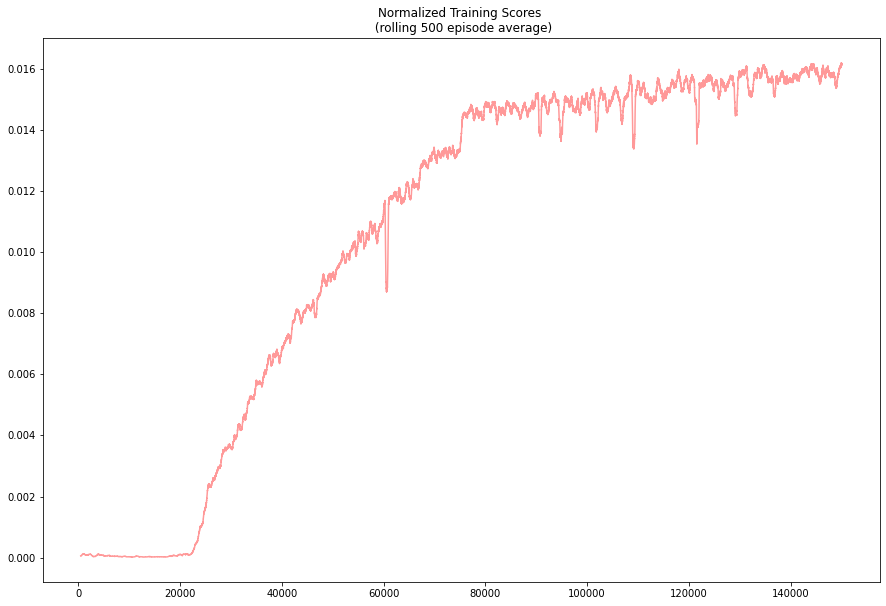

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sb.lineplot(x=a_episode_count, y=a_rolling_red_scores, ax=ax, color='red', alpha=0.4)
#sb.lineplot(x=a_episode_count, y=a_rolling_blue_scores, ax=ax, color='blue', alpha=0.4)
plt.title('Normalized Training Scores \n (rolling 500 episode average)')
plt.savefig('normalized_training_scores.png', bbox_inches='tight')
plt.show()